# Speed control in biological sequence-generating network

The overarching goal of this suite of notebooks (prefixed with 'D') is to investigate 'modified' synfire chains that stably propagate input excitation introduced to the chain and permit the modulation of their propagation speeds via external global inhibition.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

### Chain structure and connectivity

The 'modified' synfire chain is constructed as follows: we first define a chainlink as a collection of neurons with random, recurrent, excitatory connections. The number of afferents each neuron receives is normalized (specifically, we specify the percentage of the total number of neurons within the chainlink from which each neuron receives afferents).

Chainlinks are then ordered, and each neuron in chainlink i+1 receives excitatory connections from each neuron
in chainlink i.

Since it is unclear whether HVC directly receives inhibition directly from UVA or whether this inhibition is facilitated through control of HVC's inhibitory neurons, UVA-modulated inhibition is simply modeled as global Poisson input to the chain. In theory, a pool of inhibitory neurons coupled to the chain could be tuned to provide similar inhibition.

![Network Diagram](./images/network_diagram.png)

# Strategy

1. Initially ignore inhibition and identify feed-forward (interchainlink) and recurrent (intrachainlink) connectivity that gives rise to 'stable' spike pulse propagation ('stable' will be defined in D2a).
    - Simulate networks within a reasonable parameter space (without inhibition) (this notebook).
        - Separately, repeat this step while introducing a small amount of adaptation.
    - Screen these networks for 'stable' spike pulse propagation (without adaptation (D2a) and with adapation (D2b)).
        
        
2. Apply inhibition at a fixed Poisson intensity while increasing the weight of inhibition until the network no longer faithfully transmits spike pulses (D3). Identify the slowest spike pulse propagation speed achieved, and calculate the ratio of uninhibited propagation speed to slowest propagation speed.

# Code
### Define reversal potentials, conductance decay timescales, network properties, and other constants

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 300, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E=0.01,
    W_U_I=0.8e-3,
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Single neuron EPSPs and IPSPs

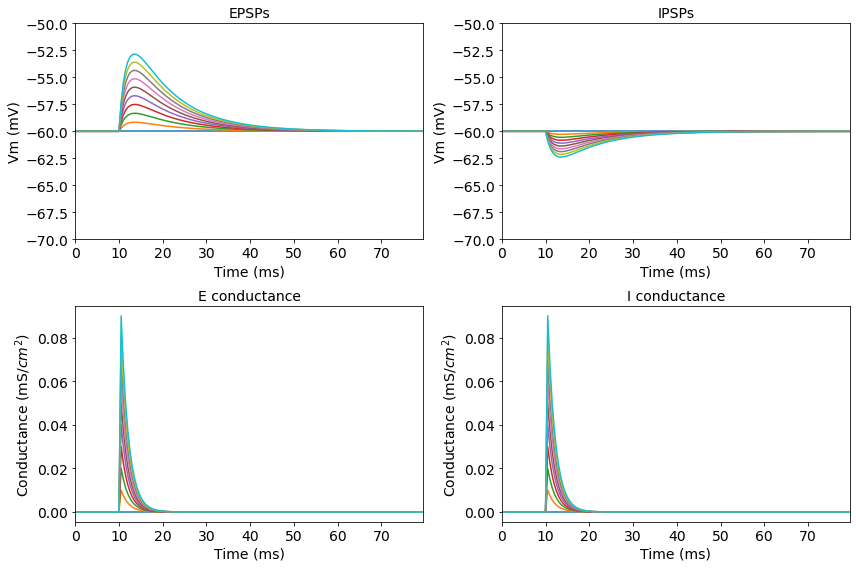

In [2]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.01e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))

    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

# Full chain

### Helper functions for defining network connectivity

In [105]:
def dropout_on_mat(mat, percent):
    dropout_indices = rand_bin_array_with_percentage_ones(mat.shape[1], int((1 - percent) * mat.shape[1]))
    m = copy(mat)
    for idx, val in enumerate(dropout_indices):
        m[:, idx] = val * m[:, idx]
    return m

## E-E weights
def make_w_r_e(m, weights, cnxn_probs):
    w_r_e = np.zeros([m.N_N]*2)

    # btwn links
    w_r_e_e = np.zeros([m.N_E]*2)
    for l_idx in range(1, m.N_L):
        row_idx = l_idx * m.N_L_E
        col_idx = (l_idx - 1) * m.N_L_E
        ff_connectivity = weights['e_e_f'] * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), cnxn_probs['e_e_f'])
        w_r_e_e[row_idx:(row_idx + m.N_L_E), col_idx:(col_idx + m.N_L_E)] = ff_connectivity
    
    # intrachainlink recurrent connections are sparsified so that each neuron receives connections from 
    # 'percent_cnxn_e_e' * N_L_E neurons
    for i in range(m.N_L):
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            weights['e_e_r'] * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), cnxn_probs['e_e_r'])

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    # connections to inhibitory neurons are also sparsified, but for this set of experiments, the weights are set to zero
    w_r_e[m.N_E:, :m.N_E] = weights['e_i'] * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_P_I), cnxn_probs['e_i'])
    
    return w_r_e

# define recurrent inhibitory connections
def make_w_r_i(m, weights, cnxn_probs):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = weights['i_e'] * sprs_mat_with_rand_percent_cnxns((m.N_P_I, m.N_E), cnxn_probs['i_e'])
    return w_r_i

# define structure of external inhibitory input
def make_w_u_i(m, weights):
    w_u_i = np.zeros([m.N_N, m.N_N + m.N_L_E])
    w_u_i[(-m.N_P_I):, (-m.N_P_I):] = weights['u_i'] * np.eye(m.N_P_I)
    return w_u_i

### Define function for simulating a single set of parameters using three different input UVA frequences

In [110]:
'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight (0 for this experiment)
        2. inhibitory -> excitatory weight (0 for this experiment)
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition (0 for this experiment)
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
        8. fraction of total neurons in prior chainlink that neuron in current chainlink receives afferents from
'''

def run_test(m_t, weights, cnxn_probs, show_connectivity=False, repeats=1, dropout={'e': 0, 'i': 0}):

    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ m_t.W_U_E * np.eye(m_t.N_L_E), np.zeros([m_t.N_L_E, m_t.N_N]) ],
            [ np.zeros([m_t.N_N - m_t.N_L_E, m_t.N_N + m_t.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i(m_t, weights)
    }
    
    ## recurrent weights
    w_r = {
        'E': make_w_r_e(m_t, weights, cnxn_probs),
        'I': make_w_r_i(m_t, weights, cnxn_probs),
        'A': m_t.W_A * np.eye(m_t.N_N),
    }
    
    w_r['E'][:, :m_t.N_E] = dropout_on_mat(w_r['E'][:, :m_t.N_E], dropout['e'])
    w_r['I'][:, m_t.N_E:] = dropout_on_mat(w_r['I'][:, m_t.N_E:], dropout['i'])

    # generate timesteps and initial excitatory input window
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .013]
    t_mask = (t_u[0] <= t) & (t < t_u[1])
    
    FQ_SPK_U_I = [400]
    all_rsps = []
    
    if show_connectivity:
        fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
        axs[0, 0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[0, 0].set_title('W_R[E]\n')
        axs[0, 1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
        axs[0, 1].set_title('W_R[I]\n')

        axs[1, 0].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[1, 0].set_title('W_U[E]\n')
        axs[1, 1].spy(w_u['I'], markersize=1)
        axs[1, 1].set_title('W_U[I]\n')

        for ax in axs.flatten():
#                 ax.set_xlim(0, 200)
#                 ax.set_ylim(200, 0)
            set_font_size(ax, 14)
    
    # run simulation for same set of parameters
    for rp_idx in range(repeats):
        
        rsps_for_trial = []
        
        ## external currents
        i_ext = m_t.SGM_N/S.DT * np.random.randn(len(t), m_t.N_N) + m_t.I_EXT_B
        
        ## inp spks
        spks_u_base = np.zeros((len(t), m_t.N_L_E + m_t.N_N), dtype=int)

        # trigger inputs
        tmp = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask.sum()-1))])
        spks_u_base[t_mask, :m_t.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m_t.N_L_E)
        
        for fq_idx, fq_spk_u_i in enumerate(FQ_SPK_U_I):

            ntwk = LIFNtwkG(
                c_m=m_t.C_M_E,
                g_l=m_t.G_L_E,
                e_l=m_t.E_L_E,
                v_th=m_t.V_TH_E,
                v_r=m_t.E_L_E,
                t_r=m_t.T_R_E,
                e_s={'E': M.E_E, 'I': M.E_I, 'A': M.E_A},
                t_s={'E': M.T_E, 'I': M.T_E, 'A': M.T_A},
                w_r=w_r,
                w_u=w_u)

            clamp = Generic(
                v={0: np.repeat(m_t.E_L_E, m_t.N_N)}, spk={})
            
            spks_u = spks_u_base.copy()
            spks_u[:, -(m_t.N_P_I):] = np.random.poisson(fq_spk_u_i * S.DT, (len(t), m_t.N_P_I))

            # run smln
            rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

            rsps_for_trial.append({
                'spks_t': copy(rsp.spks_t),
                'spks_c': copy(rsp.spks_c),
                'spks_u': spks_u_base.nonzero(),
            })
            
        all_rsps.append(rsps_for_trial)

    return all_rsps

In [111]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

In [112]:
def quick_plot(m, weights, cnxn_probs, dropout,
               overlay=False, repeats=1, show_connectivity=True, n_show_only=None):
    all_rsps = run_test(m, weights, cnxn_probs,
                        dropout=dropout, show_connectivity=show_connectivity, repeats=repeats)
    
    inv_slope_rs = []
    
    for idx_r, rsps in enumerate(all_rsps):
        show_trial = (type(n_show_only) is int and idx_r < n_show_only)

        if overlay and show_trial:
            gs = gridspec.GridSpec(4, 1)
            fig = plt.figure(figsize=(10, 16), tight_layout=True)
            axs = [fig.add_subplot(gs[0:2]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3:])]

        colors = ['red', 'blue', 'green']
        inv_slopes = []
        
        frq_trial_num = len(rsps)

        for frq_idx, frq_res in enumerate(rsps):
            tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
            mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
            x = np.arange(m.N_L) + 1
            slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]

            inv_slope = 1./slp
            inv_slopes.append(inv_slope)
            
            if show_trial:
                if not overlay:
                    gs = gridspec.GridSpec(4, 1)
                    fig = plt.figure(figsize=(10, 16), tight_layout=True)
                    axs = [fig.add_subplot(gs[0:2]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3:])]

                raster = np.stack([frq_res['spks_t'], frq_res['spks_c']])
                inh_raster = raster[:, raster[1, :] >= m.N_E]
                exc_raster = raster[:, raster[1, :] < m.N_E]

                axs_1_color = 'red' if not overlay else colors[frq_idx]

                axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E + frq_idx * m.N_P_I,
                               s=1, c=axs_1_color, zorder=0, alpha=.8)
                axs[1].set_ylabel('Inh Cell Index')
                axs[1].set_xlabel('Time (ms)')
                axs[1].set_ylim(-1, frq_trial_num * m.N_P_I)

                for i in range(2):
                    axs[i].set_xlim(0, S.T * 1000)

                axs[0].set_title(f'Inhibition: {int(frq_idx * 400)} Hz')
                axs[0].set_ylim(-1, m.N_E)
                axs[0].set_ylabel('Exc Cell Index')
                axs[0].set_xlabel('Time (ms)')
                axs[2].set_ylim(3100, 3200)
                axs[2].set_ylabel('Exc Cell Index')
                axs[2].set_xlabel('Time (ms)')

                for l_cntr in range(m.N_L):
                    link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
                    link_spks = exc_raster[:, link_window]
                    if overlay:
                        c = colors[frq_idx]
                    else:
                        c = 'black' if l_cntr % 2 == 0 else 'grey'
                    axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                    axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                    axs[0].plot(link_spks[0, :] * 1000, m.N_L_E * (link_spks[0, :] - icpt) * inv_slope, c='black')
        inv_slope_ratio = inv_slopes[0] / inv_slopes[-1]
        inv_slope_rs.append(inv_slope_ratio)
        if overlay and show_trial:
            axs[0].set_title(f'inv_slp: {inv_slope_ratio}')
    return np.array(inv_slope_rs)

array([ 1.,  1., nan,  1., nan, nan,  1.,  1.,  1.,  1.])

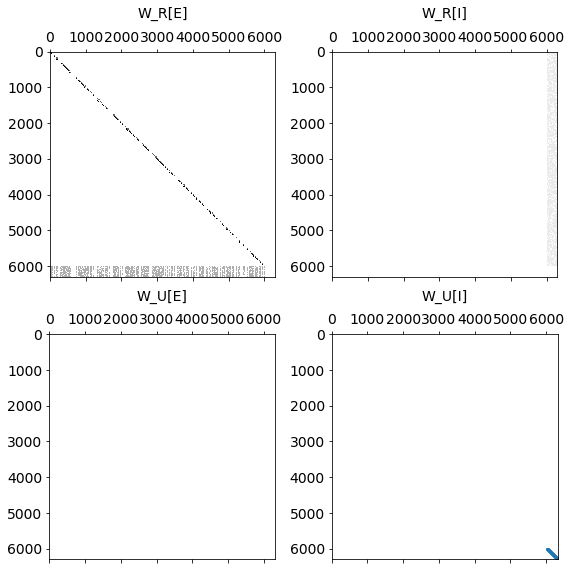

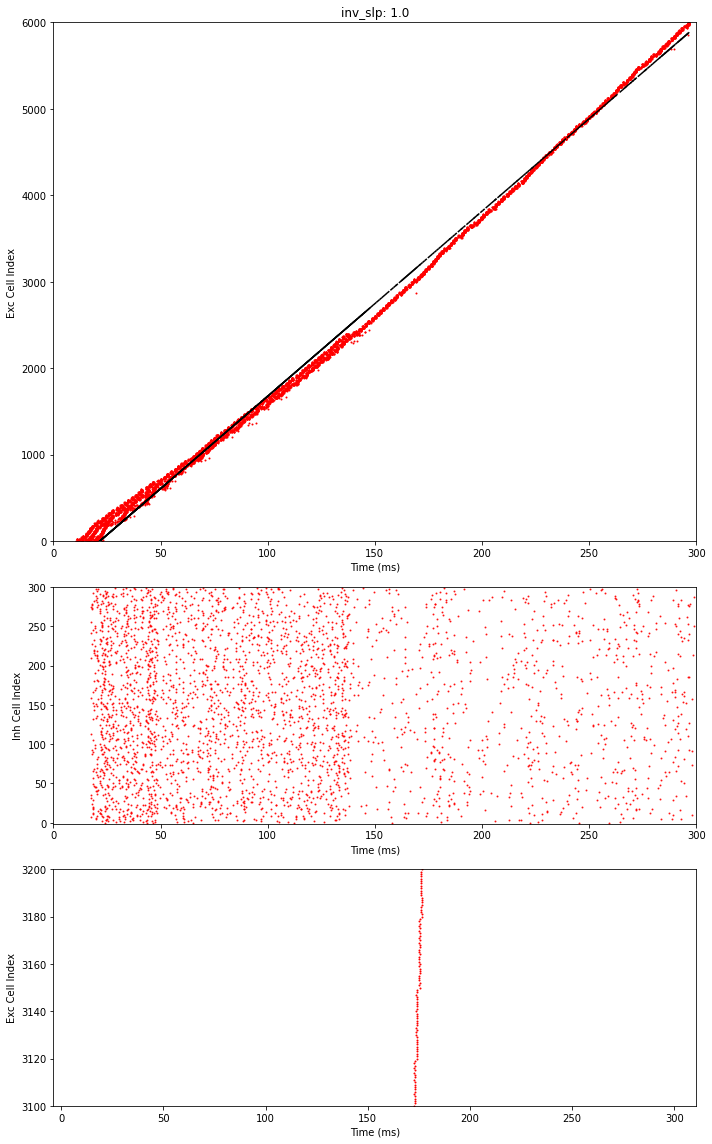

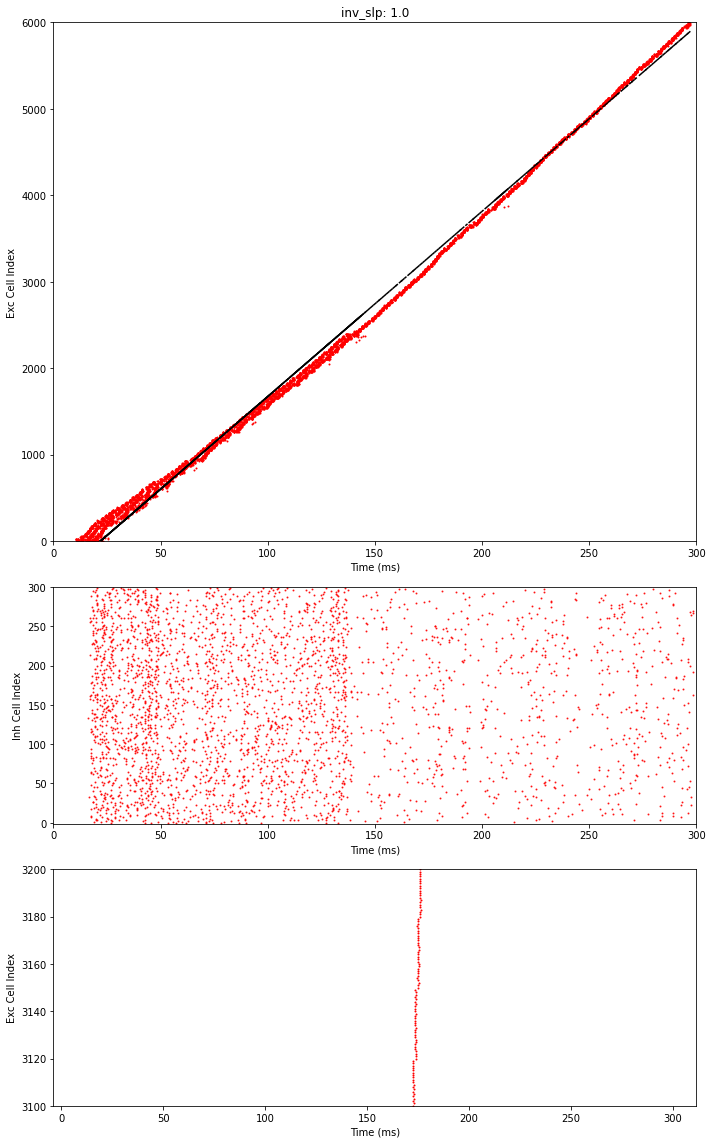

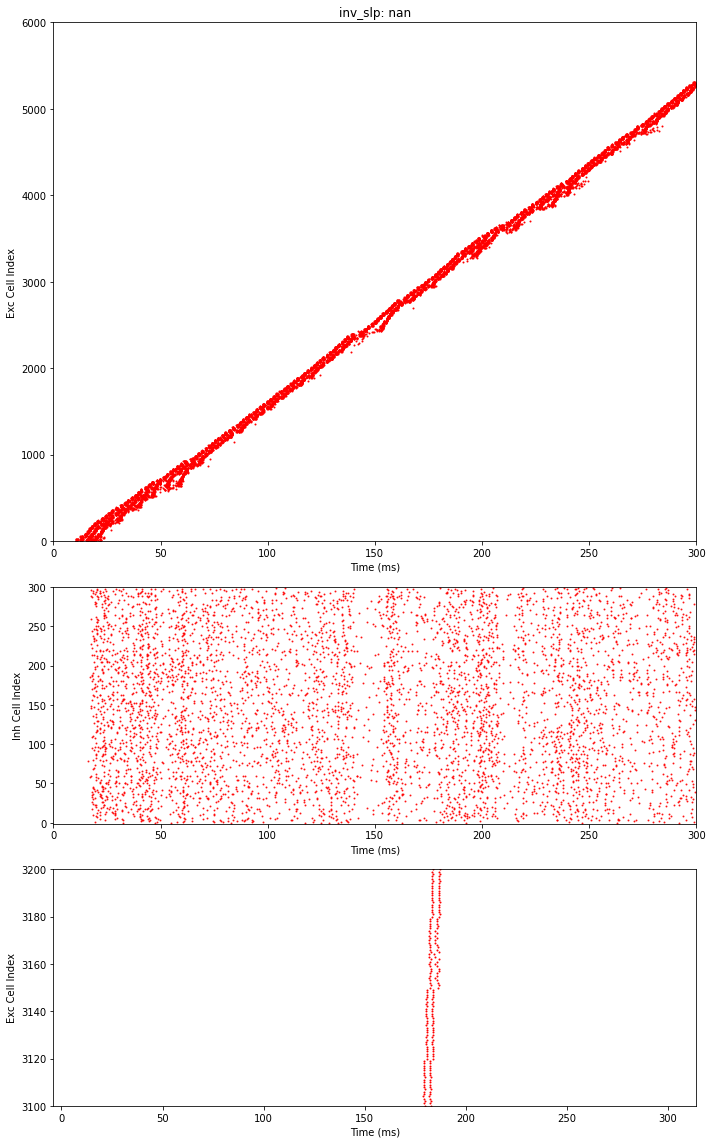

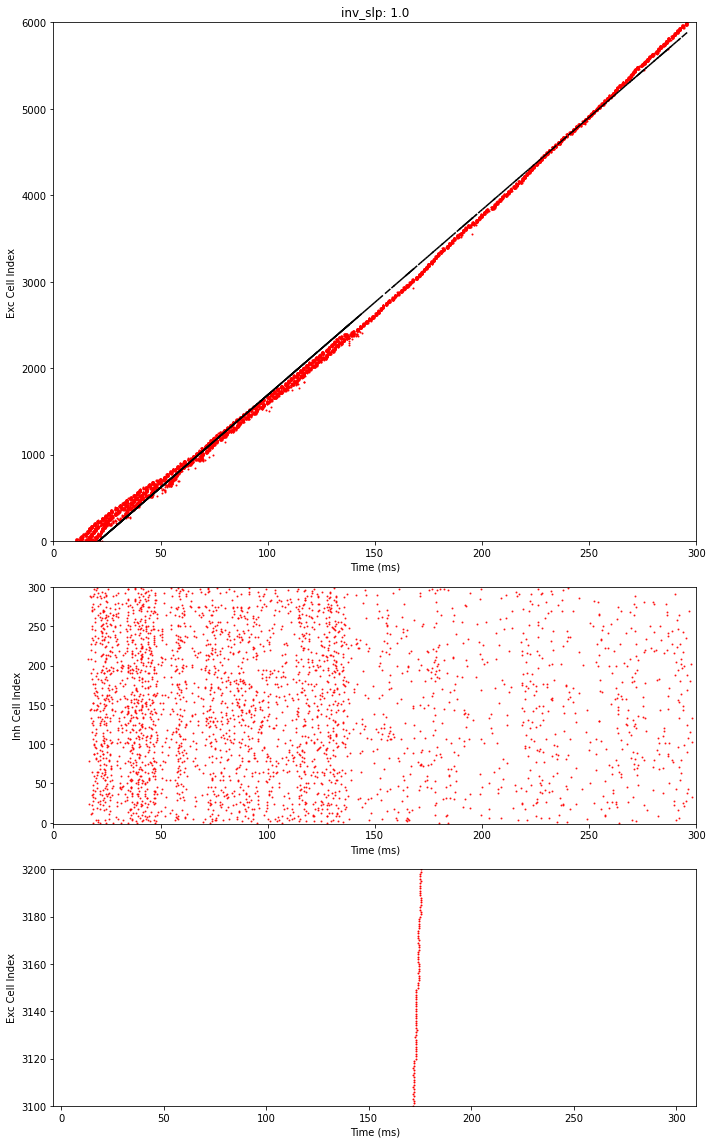

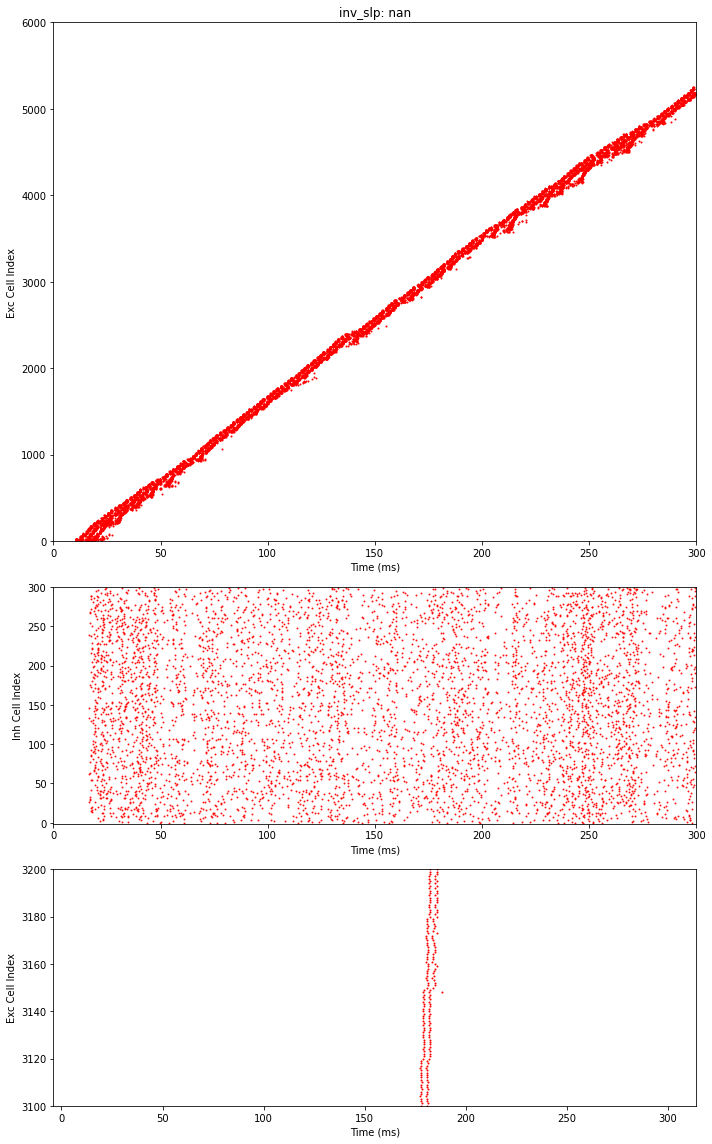

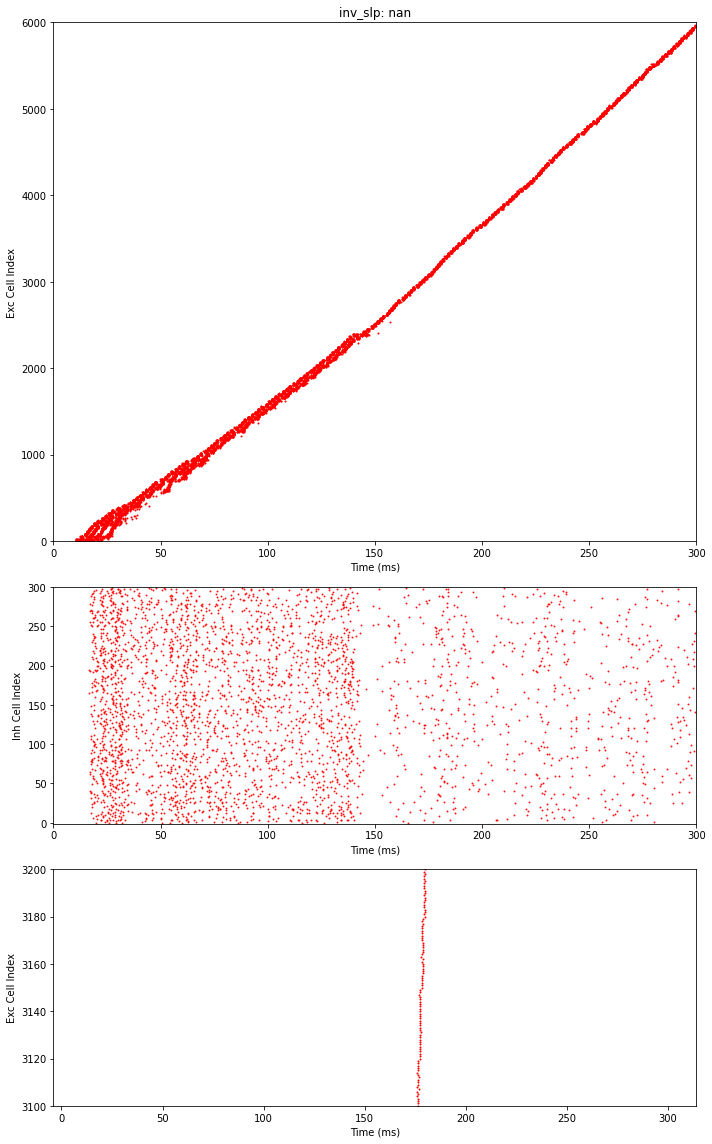

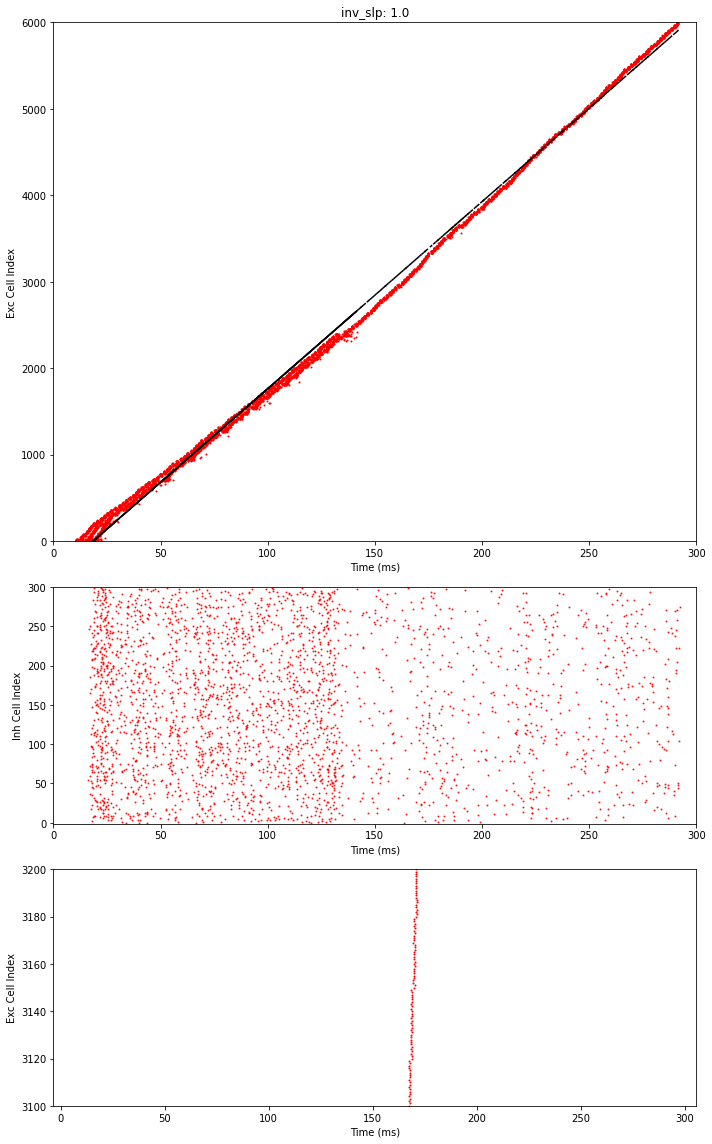

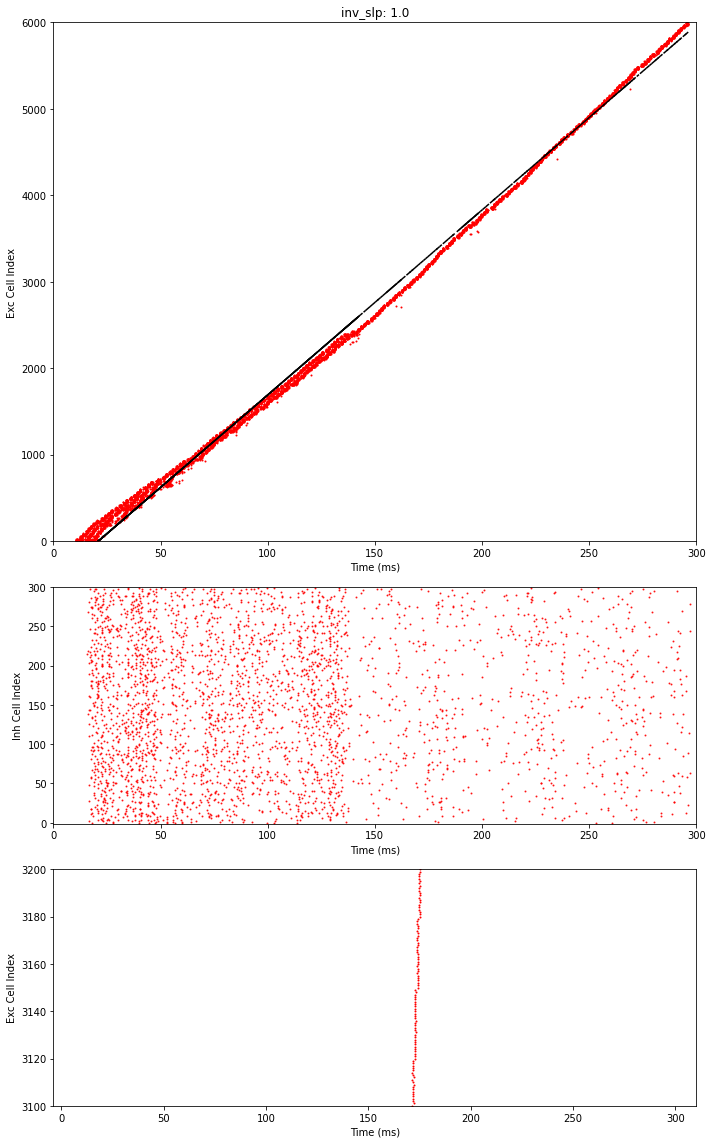

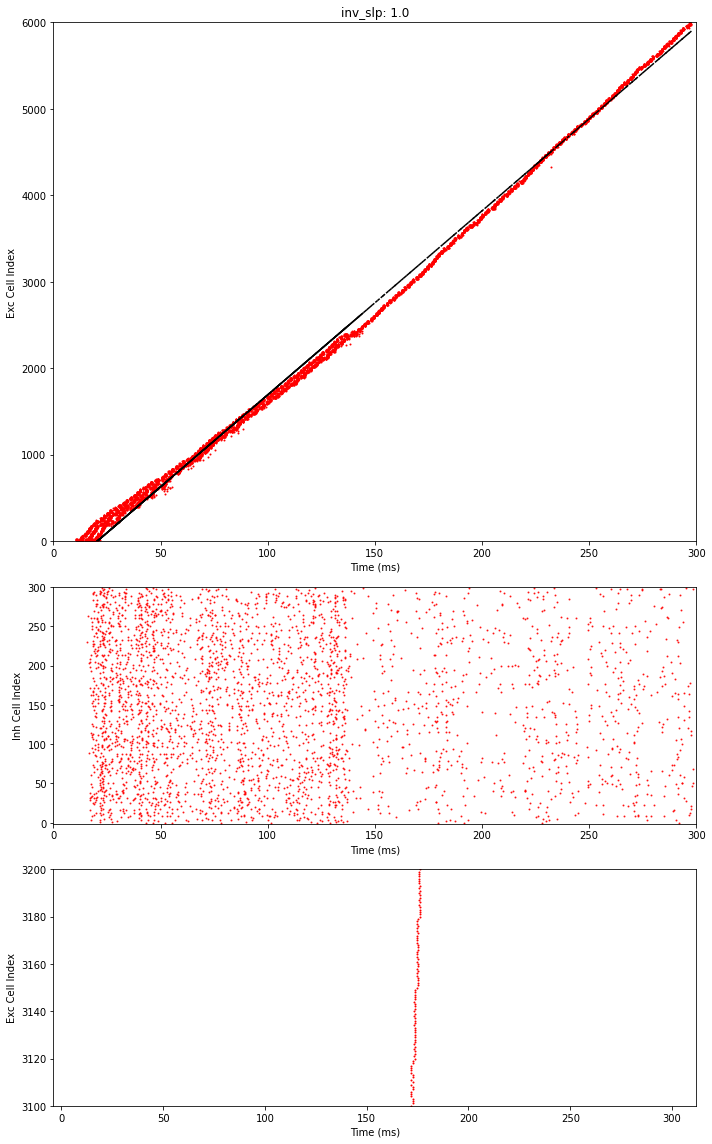

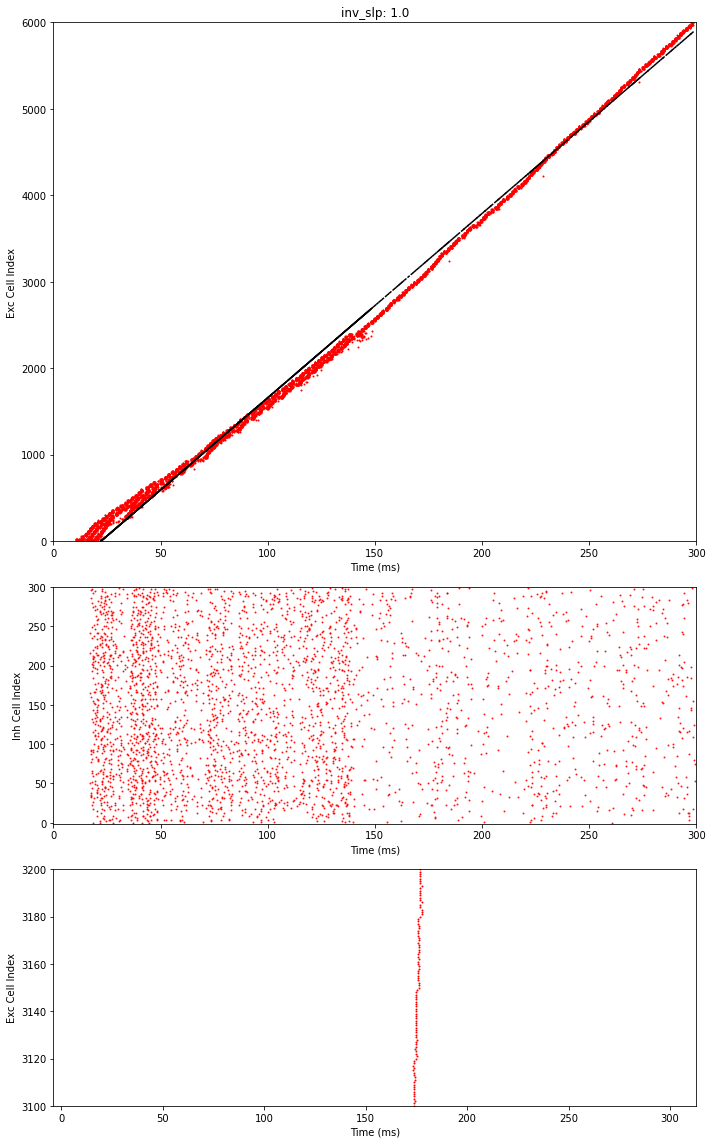

In [117]:
S.T = 0.3
m_2 = copy(m_t)
m_2.N_L_E = 30
m_2.N_L = 200
set_dynamic_vars(m_2)

'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight (0 for this experiment)
        2. inhibitory -> excitatory weight (0 for this experiment)
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition (0 for this experiment)
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
        8. fraction of total neurons in prior chainlink that neuron in current chainlink receives afferents from
'''
alpha = 0.8e-6

quick_plot(m_2, {
    'e_i':   4 * alpha,
    'i_e':   alpha,
    'e_e_r': 6e-6,
    'e_e_f': 16e-6,
    'u_i':   0.8e-3,
}, {
    'e_i':   0.75,
    'i_e':   0.75,
    'e_e_r': .7,
    'e_e_f': .7,
}, {
    'e': 0.3,
    'i': 0,
}, n_show_only=10, overlay=True, repeats=10)